# Download the Data

In [1]:
!pip3 install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [4]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [5]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [6]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [7]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5833
1516


# Visualize Data

In [8]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['yorkshire_terrier', 'japanese_chin', 'Bombay', 'american_pit_bull_terrier', 'boxer', 'samoyed', 'english_setter', 'British_Shorthair', 'Ragdoll', 'Siamese', 'basset_hound', 'Maine_Coon', 'chihuahua', 'havanese', 'great_pyrenees', 'english_cocker_spaniel', 'Sphynx', 'german_shorthaired', 'Egyptian_Mau', 'pug', 'scottish_terrier', 'Abyssinian', 'miniature_pinscher', 'american_bulldog', 'pomeranian', 'Russian_Blue', 'saint_bernard', 'beagle', 'staffordshire_bull_terrier', 'leonberger', 'shiba_inu', 'Birman', 'keeshond', 'newfoundland', 'wheaten_terrier', 'Bengal', 'Persian']

Num of classes: 37


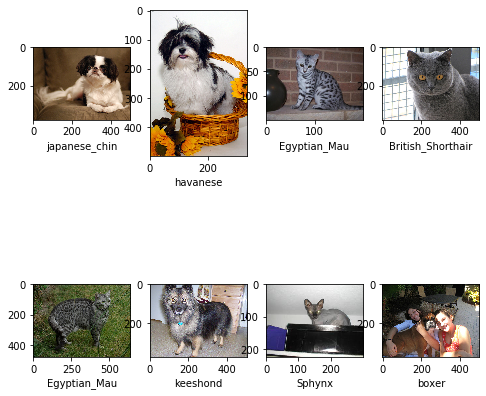

In [9]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [12]:
role = sagemaker.get_execution_role()
bucket_name = 'bucket-image-classification'
# training_image = get_image_uri(boto3.Session().region_name, 'image-classification', repo_verion='latest')
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:1


In [13]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [14]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [15]:
prepare_data(train_annotations, 'train')

100%|██████████| 5833/5833 [00:01<00:00, 4924.98it/s]


In [16]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1516/1516 [00:00<00:00, 2879.54it/s]


# Uploading Data to S3

In [21]:
sess = sagemaker.Session()

In [24]:
%%time
sess = sagemaker.Session()

s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('train image uploaded')

s3_train_lst_path = sess.upload_data(path='train_lst', bucket=bucket_name, key_prefix='train_lst')
print('train list uploaded')

s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
print('train list uploaded')

s3_validation_lst_path = sess.upload_data(path='validation_lst', bucket=bucket_name, key_prefix='validation_lst')
print('validation list uploaded')

train image uploaded
train list uploaded
train list uploaded
validation list uploaded
CPU times: user 47.5 s, sys: 3.34 s, total: 50.9 s
Wall time: 8min 11s


In [25]:
print(s3_train_path, s3_train_lst_path, s3_validation_path, s3_validation_lst_path)

s3://bucket-image-classification/train s3://bucket-image-classification/train_lst s3://bucket-image-classification/validation s3://bucket-image-classification/validation_lst


# SageMaker Estimator

In [26]:
%%time
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://bucket-image-classification/out',
    sagemaker_session=sess
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 1.29 ms, sys: 111 µs, total: 1.4 ms
Wall time: 989 µs


# Hyperparameters

In [28]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=37,
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=train_count,
    use_weighted_loss=1,
    augmentation_type='crop_color_transform',
)

# Data Channels

In [37]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated', 
                                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                                             content_type='application/x-image', s3_data_type='S3Prefix')
train_lst_data = sagemaker.session.s3_input(s3_train_lst_path, distribution='FullyReplicated', 
                                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data = sagemaker.session.s3_input(s3_validation_lst_path, distribution='FullyReplicated',
                                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data,
                'train_lst': train_lst_data, 'validation_lst': validation_lst_data}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


# Model Training

In [39]:
model.fit(inputs=data_channels, logs=True)

2020-11-02 15:56:50 Starting - Starting the training job...
2020-11-02 15:56:52 Starting - Launching requested ML instances......
2020-11-02 15:58:19 Starting - Preparing the instances for training......
2020-11-02 15:59:21 Downloading - Downloading input data.........
2020-11-02 16:00:48 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[11/02/2020 16:00:52 INFO 139841512658752] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[11/02/2020 16:00:52 INFO 139841512658752] Merging with provided configuration from /opt/ml/input/config/

# Deploy Model

In [40]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('nModel deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!nModel deployed!


# Predictions

In [41]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1516


In [42]:
deployed_model.content_type = 'image/jpeg'

In [47]:
index = 9

image_path = os.path.join(image_dir, images[index])

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results = json.loads(results)

print(results)

[4.40681105828844e-05, 1.1339054140080407e-08, 2.1270554498187266e-05, 0.00021910738723818213, 9.750468876745799e-08, 7.016328407161154e-09, 4.169048679614207e-06, 1.3706054069473339e-08, 3.5006411658322634e-10, 1.3409970733846421e-06, 1.8244136299472302e-06, 2.2767594753947407e-10, 3.5360284527996555e-05, 4.968259403881348e-08, 3.975329398997474e-09, 6.663229523695691e-09, 1.0699475751607679e-05, 4.89561862195842e-05, 3.7937854813208105e-07, 2.8551750801852904e-05, 8.863682523951866e-06, 1.1881245427503018e-06, 0.9992759823799133, 5.25980567545048e-07, 6.342657599134327e-08, 4.747576531372033e-05, 2.0227250274729158e-07, 1.2268781119928462e-06, 0.0002382379025220871, 1.5670930109124015e-09, 3.987166110164253e-06, 4.317844415346883e-10, 2.6840502869163174e-06, 5.467751584831149e-09, 1.6255556900546253e-08, 3.406107225600863e-06, 9.47166469700278e-08]


In [48]:
classes[np.argmax(results)]

'miniature_pinscher'

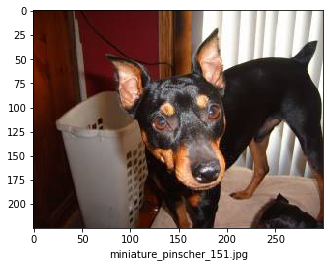

In [49]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [50]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)